## Kaggle Bosch Production Line Challenge
The Kaggle Bosch challenge aiming to predict the failed products in a production line.The production line dataset is one of the largest public manufacturing datasets. Each observation represents a product, which moves through a production line. The features are anonymized. The naming of the feature follows the convention of “L#_S##_F####”, which representing the line, station, and feature number. The ground truth of whether a product is a failure is provided as a binary class, with 1 representing failure and 0 representing pass. The goal is to use the features to predict the failed product.

# 0 Preprocess
Load libraires, data audit, remove constant columns

## 0.0 load libraries

In [1]:
# load libraries
import pandas
import numpy as np 
from sklearn import cross_validation as cv
from sklearn.metrics import matthews_corrcoef
from sklearn import preprocessing
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

%matplotlib inline

C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\sparsetools\__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._min_spanning_tree import minimum_spanning_tree
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\sparsetools\_graph_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._graph_tools import csgraph_to_dense, csgraph_from_dense,\
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\sparsetools\__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._traversal import connected_components
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\extmath.py:20: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._logistic_sigmoid import _log_logistic_sigmoid
C:\Users\Dalaska\AppData\Roaming\Python\Python27\s

Read the dataset in float16 format to conserve memory

In [2]:
# read the dataset
start = time.time()
X_train_all = pandas.read_csv("train_numeric.csv",dtype='float16')
print(X_train_all.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1183747 entries, 0 to 1183746
Columns: 970 entries, Id to Response
dtypes: float16(970)
memory usage: 2.1 GB
None


## 0.1 Load data

Randomly shuffle data, the select n rows

In [3]:
# shuffle, randomize the data set
X_train_all = X_train_all.iloc[np.random.permutation(len(X_train_all))]

In [4]:
# select n data to speed up
i = 10000
X_train = X_train_all[:i]

## 0.2 Seperate training and testing set

In [5]:
# labels
y_train = X_train['Response'] # get the label of the training set
# features
X_train = X_train.drop(['Id','Response'], axis=1) # remove the columns of ID and Label in training set

print("Train set size: {}".format(X_train.shape))

Train set size: (10000, 968)


## 0.3 Data summary

Basics statistics

In [6]:
# training set
print ("Training set:")
n_data  = len(X_train)
# exclude first colum ID and last column label (substract 2)
n_features = X_train.shape[1]
# number of satisfied customers
n_sat = len(y_train[y_train == 0]) 
# number of dissatisfied customers
n_unsat = len(y_train[y_train == 1]) 
sat_rate = 100.0*n_unsat/n_sat
print ("# data: {}".format(n_data))
print ("# features: {}".format(n_features))
print ("# passed: {}".format(n_sat))
print ("# failed: {}".format(n_unsat))
print ("% failure rate: {:.3f}%".format(sat_rate))

Training set:
# data: 10000
# features: 968
# passed: 9943
# failed: 57
% failure rate: 0.573%


Print the a feature summary, max, min std

In [7]:
## summary
X_train.describe()

C:\Users\Dalaska\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Users\Dalaska\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
count,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,...,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.000385,-0.001043,-0.001509,-0.001362,-0.001517,0.001283,-0.000028,0.000583,-0.001062,-0.001015,...,-0.000003,-0.000004,0.000186,0.000036,0.000052,0.002016,-0.000006,0.000010,0.000012,0.000040
std,0.080505,0.093140,0.211548,0.211548,0.094788,0.164307,0.019562,0.105774,0.115295,0.113464,...,0.146973,0.000000,0.002869,0.000488,0.000345,0.250488,0.000000,0.000244,0.000000,0.000345
min,-0.407959,-0.422119,-0.396973,-0.396973,-0.404053,-0.565918,-0.052002,-0.232056,-0.393066,-0.344971,...,-0.302002,-0.001000,0.000000,0.000000,0.000000,-0.250000,-0.001000,0.000000,0.000000,0.000000
25%,-0.049011,-0.064026,-0.178955,-0.178955,-0.056000,-0.065979,-0.014999,-0.072021,-0.081970,-0.083008,...,-0.112000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000
50%,0.003000,0.004002,-0.032990,-0.033997,0.031006,0.070007,0.000000,-0.032013,-0.005001,0.002001,...,-0.008001,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
75%,0.056000,0.062988,0.293945,0.293945,0.031006,0.116028,0.014999,0.088013,0.075989,0.077026,...,0.082230,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
max,0.258057,0.280029,0.566895,0.565918,0.291992,0.206055,0.088989,0.488037,0.427979,0.483887,...,0.452881,0.000000,0.045013,0.007000,0.003000,0.250000,0.001000,0.005001,0.003000,0.007000


## 0.4 Replace missing data

In [8]:
# replace nan with large num
X_train.fillna(value = -2, inplace = True)
# replace with mean
#X_all.fillna(X_all.mean(), inplace = True)

## 0.5 Sparsity

Count the the percentage of missing data

In [9]:
# count the the percentage of missing data in each feature
def countNan(X_train):
    n_data  = len(X_train) # number of rows
    Na_Num = [0] * n_data
    headers = list(X_train.columns.values)
    xm = X_train.as_matrix() # convert data set to array
    m = 0 # inicialized
    for i in range(X_train.shape[0]):
        count = 0
        for j in range(X_train.shape[1]):
            if xm[i][j] < -1.99:
                count = count + 1
        Na_Num[m]= 1.0*count/n_data
        m = m+1
    return Na_Num

In [10]:
# count the percentage of missing data
Na_Num = countNan(X_train )

In [11]:
# total sparsity to percent
print ("Total sparsity of the dataset: {:.3f}%".format(np.mean(Na_Num)))

Total sparsity of the dataset: 0.078%


Plot the distribution of features with missing values

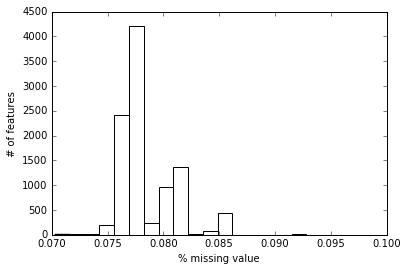

In [12]:
# The distribution of features with missing values
plt.hist(Na_Num,20,color='w')
plt.xlabel("% missing value")
plt.ylabel("# of features")

## 0.6 remove constant columns

In [13]:
# remove constant columns
colsToRemove = []
for col in X_train.columns:
    # column have 0 standard deviation
    if X_train[col].std() == 0: 
        colsToRemove.append(col)
# remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True) 
# remove constant columns in the test set
print("# removed constant columns: {}".format(len(colsToRemove)))  

# removed constant columns: 0


# 1. Clustering

Create a binary features to describe  wehter the feature is missing in a process

## 1.0 Create binary features

In [14]:
# inicalize a dataframe to hold binary values
X_train_bi = X_train.copy()

In [15]:
# O:the data is missing, 1:the data is present

In [16]:
headers = list(X_train.columns.values)
for i in headers:
    X_train_bi.loc[X_train[i] > -1.99 , i] = 1
    X_train_bi.loc[X_train[i] < -1.99 , i] = 0

In [17]:
# convert the data frame to int to save memory
X_train_bi = X_train_bi.astype('int8')
print(X_train_bi.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 479094 to 751347
Columns: 968 entries, L0_S0_F0 to L3_S51_F4262
dtypes: int8(968)
memory usage: 9.3 MB
None


## 1.1 PCA

In [18]:
# n_components equal # feature
pca = PCA(n_components= X_train_bi.shape[1]) 
pca.fit(X_train)

PCA(copy=True, n_components=968, whiten=False)

## 1.2 Variance explaining ratio

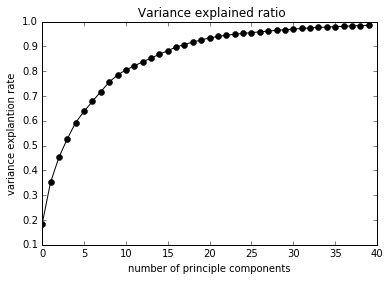

In [19]:
# plot variance explained ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_[:40]),'-ko')
plt.xlabel('number of principle components')
plt.ylabel('variance explantion rate')
plt.title(" Variance explained ratio")

## 1.3 Visualization

Reduce the feature dimension to 2d

In [20]:
# Project on 2 PCs
pca_2d = PCA(n_components = 2) # 2 principle components
pca_2d.fit(X_train)
# reduce the dataset to 2 pcs
reduced_data = pca_2d.fit_transform(X_train) 

C:\Users\Dalaska\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


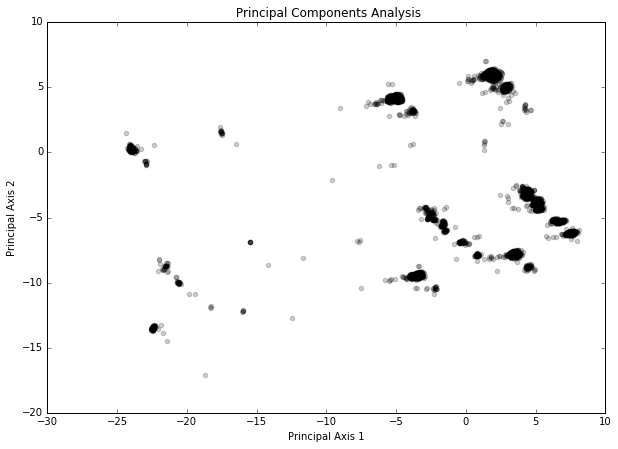

time (secs): 109.835


In [21]:
# Visualization PCA in 2D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
#colors = [(0.0, 0.63, 0.69), 'black']
colors = [ 'black']
classes = [0,1]
#labels = ["passed", "failed"]
labels = [""]
markers = ["o"]
#markers = ["o", "D"]
for class_ix, marker, color, label in zip(classes, markers, colors, labels):
    ax.scatter(reduced_data[:, 0],
               reduced_data[:, 1],
               marker=marker, color=color, 
               #edgecolor='whitesmoke',
               linewidth='1', alpha=0.2, label=label)
    ax.legend(loc='best')
plt.title(" Principal Components Analysis")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.show()
end = time.time()
print ("time (secs): {:.3f}".format(end - start))

In [22]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\neighbors\__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .ball_tree import BallTree
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\neighbors\__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .kd_tree import KDTree
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\graph.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .graph_shortest_path import graph_shortest_path
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\isotonic.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._isotonic import _isotonic_regression
C:\Users\Dalaska\AppData\Roaming\Python\Python27\site-packages\sklearn\manifold\t_sne.py:21: RuntimeWarning: numpy.dtype size changed, may indicate binary

## 1.4 Choose the number of cluster

load libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans


Evaluation of KMeans with random init


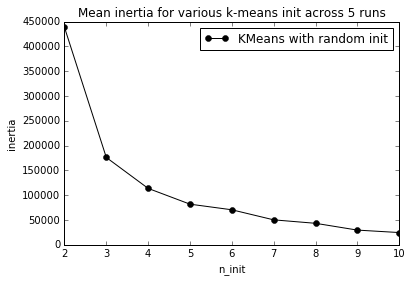

In [25]:
random_state = np.random.RandomState(42)
# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 5 # number of repeating

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness

N_clusters = [2,3,4,5,6,7,8,9,10]
n_init = 3;
# Part 1: Quantitative evaluation of various init methods

fig = plt.figure()
plots = []
legends = []

cases = [ (KMeans, 'random', {})]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(N_clusters), n_runs))

    for run_id in range(n_runs):
        #X, y = make_data(run_id, n_samples_per_center, grid_size, scale)  
        X = reduced_data
        #for i, n_init in enumerate(n_init_range):
        for i, n_clusters in enumerate(N_clusters):
            km = factory(n_clusters=n_clusters, init=init, random_state=run_id,
                         n_init=n_init, **params).fit(X)
            inertia[i, run_id] = km.inertia_
    #p = plt.errorbar(N_clusters, inertia.mean(axis=1), inertia.std(axis=1))
    p = plt.plot(N_clusters, inertia.mean(axis=1),'-ko')
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))
#print(inertia)
plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

The number of cluster is set to be 6 

## 1.6 Cluster

Cluster the data based on the manufacture process

In [26]:
from sklearn import mixture
clusters= KMeans(n_clusters=6, random_state=42)
clusters.fit(reduced_data) 
print (clusters)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=42, tol=0.0001,
    verbose=0)


In [27]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [28]:
import numpy 
centroids = clusters.cluster_centers_
np.set_printoptions(precision=2, suppress=True) # set printing format
print ("Centroids:")
print (centroids)

Centroids:
[[  5.16  -6.01]
 [ -5.     4.1 ]
 [  1.92   5.87]
 [-21.5  -12.1 ]
 [ -2.89  -8.39]
 [-23.65   0.3 ]]


## 1.7 visualize the cluster

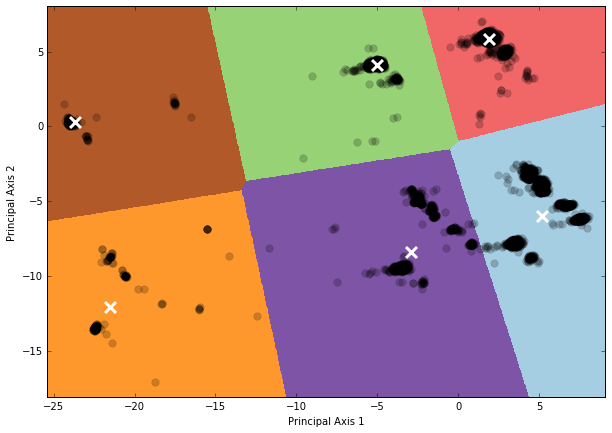

In [29]:
# Put the result into a color plot
def visual(Z,xx,yy,centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 7))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.Paired,
                   aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=15, alpha=0.2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=120, linewidths=3,
                    color='w', zorder=10)
    #plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
    #              'Centroids are marked with white cross')
    plt.xlabel("Principal Axis 1")
    plt.ylabel("Principal Axis 2")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()

visual(Z,xx,yy,centroids)

## 2 Model Selection 

## 2.1 train the classifier

In [30]:
# Train a model
def train_classifier(clf, X_Train, y_Train):
    #print ("{}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_Train, y_Train)
    end = time.time()
    train_time = end - start
    return clf,train_time

In [31]:
# debug
#clf,train_time = train_classifier(clf1, X_cv_train, y_cv_train)

## 2.2 Predict labels

In [32]:
# For parameter tuning
# Predict on training set and compute matthews corrcoef
from sklearn.metrics import roc_auc_score
def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict_proba(features)
    end = time.time()
    auroc = roc_auc_score(target, y_pred[:,1]) # select column
    p_val,mcc  = find_p(y_pred[:,1],target )
    return y_pred[:,1],p_val,mcc,auroc

## 2.3 Optimize MCC

In [33]:
# optimized MCC
def find_p(y_prob,y_target ):
    grid = np.multiply(0.01,range(100)) 
    # tune p
    p_list = []
    pred = [0]*len(y_prob)
    for p in grid:
        for i in range(len(y_prob)):        
            if y_prob[i] > p:
                pred[i] = 1
            else:
                pred[i] = 0       
        score = matthews_corrcoef(y_target, pred)
        p_list.append(score)
    p_val = grid[p_list.index(max(p_list))]
    best_score  = max(p_list)
    
    return p_val , best_score 

## 2.4 Crossvalidation

In [34]:
# For parameter tuning
# Train and predict using different training set sizes
def train_predict(clf, X_Train, y_Train, X_Test, y_Test):
    clf,train_time = train_classifier(clf, X_Train, y_Train)
    y_p_train, p_val_train , mcc_train, auc_train = predict_labels(clf, X_Train, y_Train)
    y_p_test,  p_val_test ,  mcc_test,  auc_test = predict_labels(clf, X_Test, y_Test)
    print ("{}...".format(clf.__class__.__name__))
    print ("     train time:{:.0f}, test mcc: {:.4f}, acu: {:.3f}, train mcc: {:.3f}, auc: {:.3f}".format(train_time,mcc_test,auc_test,mcc_train,auc_train ))
    return clf,y_p_test, p_val_test, p_val_train, mcc_test , auc_train

In [35]:
# debug
#clf,y_p_test, p_val_test, p_val_train, mcc_test , auc_train = train_predict(clf, X_cv_train, y_cv_train, X_cv_test, y_cv_test)

load libaries

In [38]:
# load libaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model 
from sklearn import naive_bayes 
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


## 2.7 Seperate training and testing

In [39]:
# First, decide how many training vs test samples you want
from sklearn.cross_validation import train_test_split

num_all = X_train.shape[0]  # same as len(student_data)
num_train = int(0.85*num_all)  # about 75% of the data
num_test = num_all - num_train

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_train, y_train, train_size = num_train)

print ("Training set: {} samples".format(X_cv_train.shape[0]))
print ("Test set: {} samples".format(X_cv_test.shape[0]))


Training set: 8500 samples
Test set: 1500 samples


## 2.8 Different models

In [40]:
clf1 = DecisionTreeClassifier()
clf2 = AdaBoostClassifier(n_estimators = 10)
clf3 = RandomForestClassifier(n_estimators = 10)
    
train_size = [1000,]
for i in train_size:
    clf1,y_pred1,p2t,p2n,mcc,auc = train_predict(clf1, X_cv_train, y_cv_train, X_cv_test, y_cv_test)
    clf2,y_pred2,p2t,p2n,mcc,auc = train_predict(clf2, X_cv_train, y_cv_train, X_cv_test, y_cv_test)
    clf3,y_pred3,p2t,p2n,mcc,auc = train_predict(clf3, X_cv_train, y_cv_train, X_cv_test, y_cv_test)
    

DecisionTreeClassifier...
     train time:5, test mcc: -0.0057, acu: 0.498, train mcc: 1.000, auc: 1.000
AdaBoostClassifier...
     train time:2, test mcc: 0.0588, acu: 0.544, train mcc: 0.149, auc: 0.880
RandomForestClassifier...
     train time:1, test mcc: 0.0962, acu: 0.516, train mcc: 0.989, auc: 1.000


## 2.9 plot ROC curve

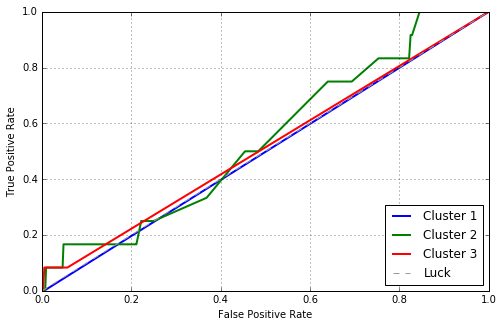

In [41]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(y_cv_test, y_pred1)
fpr2, tpr2, thresholds2 = roc_curve(y_cv_test, y_pred2)
fpr3, tpr3, thresholds3 = roc_curve(y_cv_test, y_pred3)

plt.figure(figsize=(8,5))
plt.plot(fpr1, tpr1, lw=2, label='Cluster 1' )
plt.plot(fpr2, tpr2, lw=2, label='Cluster 2' )
plt.plot(fpr3, tpr3, lw=2, label='Cluster 3' )
plt.plot([0, 1], [0, 1],'--', color=(0.6, 0.6, 0.6), label='Luck')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

## 3.0 Model refining

ftr: 20 ,dpt: 2 ,lef: 4
RandomForestClassifier...
     train time:0, test mcc: 0.0000, acu: 0.475, train mcc: 0.044, auc: 0.566
ftr: 20 ,dpt: 2 ,lef: 5
RandomForestClassifier...
     train time:0, test mcc: 0.0000, acu: 0.475, train mcc: 0.044, auc: 0.566
ftr: 20 ,dpt: 3 ,lef: 4
RandomForestClassifier...
     train time:0, test mcc: 0.0141, acu: 0.500, train mcc: 0.094, auc: 0.607
ftr: 20 ,dpt: 3 ,lef: 5
RandomForestClassifier...
     train time:0, test mcc: 0.0141, acu: 0.500, train mcc: 0.090, auc: 0.607
ftr: 30 ,dpt: 2 ,lef: 4
RandomForestClassifier...
     train time:0, test mcc: 0.0033, acu: 0.472, train mcc: 0.073, auc: 0.553
ftr: 30 ,dpt: 2 ,lef: 5
RandomForestClassifier...
     train time:0, test mcc: 0.0033, acu: 0.472, train mcc: 0.045, auc: 0.552
ftr: 30 ,dpt: 3 ,lef: 4
RandomForestClassifier...
     train time:0, test mcc: 0.0040, acu: 0.472, train mcc: 0.199, auc: 0.566
ftr: 30 ,dpt: 3 ,lef: 5
RandomForestClassifier...
     train time:0, test mcc: 0.0033, acu: 0.472, train

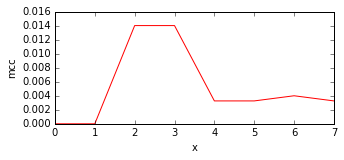

In [43]:
# use grid search to optimized the parameters
# max_depth
y = [2,3] #8
# max_feature
x = [20,30] #7
# tree leaf
z = [4,5] # 9

# save the result into a list
MCC =[] # mcc score
ftr = [] # number of feature
dpt = [] # tree depth
lef = [] # min leaf
pt = [] # threshold
AUC = [] # aus score

for i in x:
    for j in y:
        for k in z:
            print ("ftr: {} ,dpt: {} ,lef: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 1,
                                         max_features = i,
                                         max_depth = j,
                                         min_samples_leaf = k,
                                         random_state = 42,) 
            clf,y_pred,p2t,p2n,mcc,auc = train_predict(clf, X_cv_train, y_cv_train, X_cv_test, y_cv_test)
            MCC.append(mcc)
            ftr.append(i)
            dpt.append(j)
            lef.append(k)
            pt.append(p2t)
            AUC.append(auc)
    
# Visual aesthetics
plt.figure(figsize=(5,2))
plt.plot(MCC, color='r')
plt.legend()
plt.xlabel('x')
plt.ylabel('mcc')

MCC2 = [x*(-1) for x in MCC]
sort_id = np.argsort(MCC2)
print('\nBest Parameters:')
for i in range(5):
    print ("mcc: {:.4f}, p:{:.2f}, auc_:{:.3f} ftr: {}, dpt: {}, lef: {}".format(MCC[sort_id[i]],pt[sort_id[i]],AUC[sort_id[i]],ftr[sort_id[i]],dpt[sort_id[i]],lef[sort_id[i]] ))